# Árboles de regresión

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("datasets/vehiculos.csv")
data = data.dropna()
print(data.shape)
data.head()

(392, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


## Conjuntos de entrenamiento y prueba

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.2)

print("Entrenamiento: " + str(len(train)))
print("Test: " + str(len(test)))

Entrenamiento: 313
Test: 79


In [4]:
columns = data.columns.values.tolist()

var_objetivo = columns[0]
var_independientes = columns[1:8]

X = train[var_independientes]
Y = train[var_objetivo]

## Árbol de regresión

In [5]:
from sklearn.tree import DecisionTreeRegressor

In [6]:
# min_samples_split = observaciones minimas que debe haber para dividir el nodo en mas decisiones
# min_samples_leaf = si hay esta cantidad se considera que es una hoja

regression_tree = DecisionTreeRegressor(min_samples_split=20, min_samples_leaf=10, random_state=0)
regression_tree.fit(X,Y)

DecisionTreeRegressor(min_samples_leaf=10, min_samples_split=20, random_state=0)

In [9]:
# Predicciones

predicciones = regression_tree.predict(test[var_independientes])

df = test.copy()
df["predicciones"] = predicciones
df[["mpg","predicciones"]].head()

,mpg,predicciones
162,15.0,15.700000
309,34.5,34.066667
258,20.2,18.860000
138,32.0,32.200000
395,38.0,22.866667


### Representación

In [10]:
from sklearn.tree import export_graphviz

In [14]:
with open("outputs/regression_tree.dot", "w") as dotfile:
    export_graphviz(regression_tree, out_file=dotfile, feature_names=var_independientes)
    dotfile.close()

In [15]:
import os
from graphviz import Source

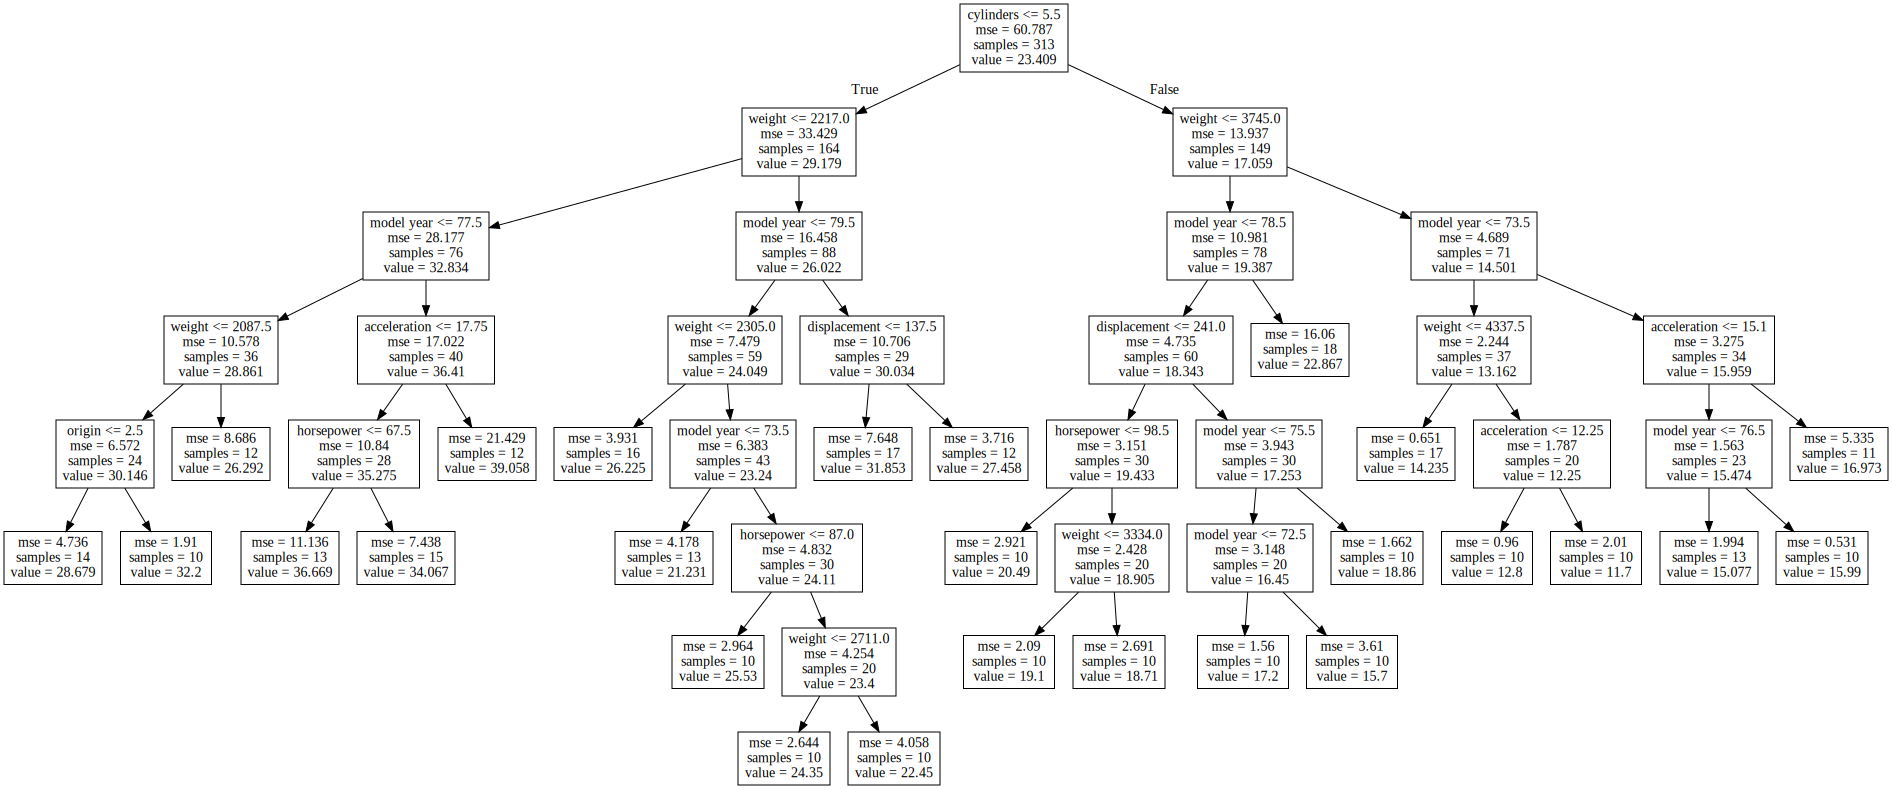

In [16]:
file = open("outputs/regression_tree.dot", "r")
text = file.read()
Source(text)

## Cross Validation
Utilizaremos el método de validación cruzada para realizar la poda del arbol, ya que si no podamos podemos tener problemas de overfitting.

In [17]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [18]:
X = train[var_independientes]
Y = train[var_objetivo]

In [24]:
for i in range(4,10):
    # modelo de aprendizaje
    rtree = DecisionTreeRegressor(min_samples_split=i*2, min_samples_leaf=i, random_state=0)
    rtree.fit(X,Y)
    
    # hacemos las subdivisiones
    conjuntos = KFold(n_splits= 10, shuffle=True, random_state=1)
    eficacias = cross_val_score(rtree, X, Y, scoring="neg_mean_squared_error", cv = conjuntos, n_jobs = 1)    
    
    eficacia = np.mean(eficacias)
    
    print('Eficacia para i [', i, " = ", eficacia, "]"", relevancias: ", rtree.feature_importances_)

Eficacia para i [ 4  =  -9.3900740807526 ], relevancias:  [0.63330013 0.02429172 0.01052773 0.17824424 0.01590733 0.13048847
 0.00724038]
Eficacia para i [ 5  =  -8.863764747123023 ], relevancias:  [0.63875105 0.02223581 0.00872924 0.18052828 0.01016886 0.13070275
 0.00888401]
Eficacia para i [ 6  =  -8.657438252905433 ], relevancias:  [0.64218328 0.01297355 0.00969006 0.18555688 0.00955482 0.13269948
 0.00734194]
Eficacia para i [ 7  =  -8.726929784699662 ], relevancias:  [0.65005341 0.01174224 0.00800711 0.18040383 0.00937023 0.13299127
 0.00743191]
Eficacia para i [ 8  =  -9.049409182065244 ], relevancias:  [0.65365521 0.01717671 0.00714544 0.17425129 0.00685354 0.13344472
 0.00747309]
Eficacia para i [ 9  =  -9.211988749698905 ], relevancias:  [0.6570422  0.01186848 0.00592279 0.17971297 0.00819081 0.13311813
 0.00414463]


> para samples 6, el error es de 8.65, que significa ese valor arriba o abajo del real

In [26]:
#Podemos observar las variables más relevantes para el modelo

list(zip(var_independientes, regression_tree.feature_importances_))

[('cylinders', 0.6601912570984677),
 ('displacement', 0.011925360529337323),
 ('horsepower', 0.005421257273033267),
 ('weight', 0.17603745332657167),
 ('acceleration', 0.008232754559931848),
 ('model year', 0.13402742444895305),
 ('origin', 0.004164492763705151)]

## Random forest
Se realizan varios modelos independientes, y el resultado final se calcula mediante votos por mayoría (en clasificación) o el promedio (en regresión) del resultado que se obtenga al aplicar cada uno de esos modelos.

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [35]:
random_forest = RandomForestRegressor(n_jobs=2, oob_score=True, n_estimators=500)

## Donde...
## jobs = numero de tareas en paralelo que se ejeuctaran para los calculos
## oob_score = el modelo hara un muestreo "out of box" aleatorio para hacer las predicciones
## estimators =  numero de arboles que va a tener el modelo del bosque

random_forest.fit(X,Y)

RandomForestRegressor(n_estimators=500, n_jobs=2, oob_score=True)

In [43]:
# observamos las predicciones del bosque para cada observacion

df = train.copy()
df["rf_prediccion"] = random_forest.oob_prediction_
df[[var_objetivo,"rf_prediccion"]]

,mpg,rf_prediccion
36,28.0,24.811053
306,27.2,26.690698
238,15.5,15.920670
364,32.9,30.481915
207,18.0,18.887912
...,...,...
147,14.0,14.615263
195,16.0,15.425414
78,19.0,22.333514
305,23.0,17.725824


In [46]:
#calculamos el promedio del error cuadratico sobre las predicciones
df["rf_err2"] = (df["rf_prediccion"]-df[var_objetivo])**2
sum(df["rf_err2"])/len(df)

## Lo podemos comparar con el de un solo arbol y vemos que hemos bajado algunos puntos

6.3901427071391765

In [51]:
# el oob_score nos da un valor de precision que podriamos comparar al coeficiente de determinación R2 en una regresión lineal
random_forest.oob_score_

0.8948768901003283

## Predicción de nuevas observaciones

In [52]:
dftest = test.copy()

dftest["rf_prediccion"] = random_forest.predict(test[var_independientes])
dftest[[var_objetivo, "rf_prediccion"]]

,mpg,rf_prediccion
162,15.0,18.2266
309,34.5,33.0286
258,20.2,18.2926
138,32.0,31.0622
395,38.0,20.3480
...,...,...
174,29.0,27.5398
388,36.0,35.8348
106,18.0,18.4002
181,18.0,20.7848
